In [1]:
import pyvista as pv
import numpy as np
from numpy import newaxis
import math
import glob
import keras
import os
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
import pathlib
import time
import datetime
import sklearn.preprocessing

%matplotlib inline

c:\Users\Vaishnav Bhaskaran\anaconda3\envs\GAN\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\Vaishnav Bhaskaran\anaconda3\envs\GAN\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [3]:
# fp_vtk = r'C:\Users\Vaishnav Bhaskaran\GAN\Data\VTK_Data\With_Hole\Aluminium'
fp_vtk = os.getcwd()

### Data Preprocessing:

In [4]:
def list_to_array(inp_list, l_type):
    dummy_list = []

    if l_type != 'bc':
        for i in range(len(inp_list)):
            dummy_list.append(list(map(float, inp_list[i].split('\n')[0].split(','))))
    else:
        for i in range(len(inp_list)):
            dummy_list += list(map(float, inp_list[i].split('\n')[0].split(',')))
    
    return(np.array(dummy_list))

In [5]:
def get_inp(filepath):

    node_list = []
    element_list = []
    bc_enc = []
    bc_load = []
    node = False
    element = False
    bc = False
    ld = False

    fp0 = filepath.split('\\')
    idx = fp0.index('Data')
    fp0 = fp0[idx:]
    fp0[-2] = str(fp0[-2][:-4] + '_inp')
    n0 = str(fp0[-1])[0:12]
    n1 = n0 + str('.inp')
    fp0.pop(-1)
    fp0.extend([n1])
    fp1 = os.path.abspath(os.path.join(*fp0))

    f_attr = file_attr(fp1)

    with open(fp1) as inp_file:
        for lines in inp_file:
            if lines.startswith('*Node'):
                node = True
            if node:
                node_list.append(lines)
            if lines.startswith('*Element'):
                node = False
                element = True
            if element:
                element_list.append(lines)
            if lines.startswith('*Nset'):
                element = False
                bc = 'nset=Dirichlet' in lines
            if bc:
                bc_enc.append(lines)
            if 'elset=Dirichlet' in lines:
                bc = False
            if lines.startswith('*Nset'):
                ld = 'nset=Set-4' in lines
            if ld:
                bc_load.append(lines)
            if 'elset=Set-4' in lines:
                ld = False

    node_list0 = list_to_array(node_list[1:-1], None)[:, 1:-1]
    element_list0 = list_to_array(element_list[1:-1], None)[:, 1:]
    bc_enc0 = list_to_array(bc_enc[1:-1], 'bc')
    bc_load0 = list_to_array(bc_load[1:-1], 'bc')
    
    return node_list0, element_list0, bc_enc0, bc_load0, f_attr

In [6]:
def cell_connectivity(n_pts, element_list0):
    
    conn0 = np.zeros((n_pts, 4))

    for cell in range(element_list0.shape[0]):
        for point_id in range(element_list0.shape[1]):
            pt = int(element_list0[cell][point_id])
            
            for idx in range(4):
                if conn0[pt-1, idx] == 0:
                    conn0[pt-1, idx] = cell + 1
                    break

    return conn0

In [7]:
def bound_cond(bc1, bc2, n_pts, load):
    bc0 = np.zeros((n_pts, 1))

    for idx in range(bc1.shape[0]):
        pt = int(bc1[idx])
        bc0[pt - 1] = -99

    for idx in range(bc2.shape[0]):
        pt = int(bc2[idx])
        bc0[pt - 1] = load

    return bc0

In [8]:
def get_load(l_type, load_idx):
    loads = {'Tensile': np.arange(0.02, 0.17, 0.02),
          'Compression': -np.arange(0.02, 0.17, 0.02),
          'Cyclic': np.arange(0.02, 0.17, 0.02)}
    
    return loads[l_type][load_idx]

In [9]:
def file_attr(filepath):

    f_attr = {}
    f1 = filepath.split('\\')
    f_idx = f1.index('VTK_Data')
    f2 = f1[f_idx+1:]

    side_idx0 = re.findall('S\d+', f2[5])
    side_idx = int(str(side_idx0[0]).split('S')[-1])

    center_idx0 = re.findall('C\d+', f2[5])
    center_idx = int(str(center_idx0[0]).split('C')[-1])

    load_idx0 = re.findall('J\d+', f2[5])
    load_idx = int(str(load_idx0[0]).split('J')[-1])

    f_attr.update(plate_type = f2[0],
                  material = f2[1],
                  nlgeom = f2[2],
                  mat_b = f2[3],
                  l_type = str(f2[4])[:-4],
                  side_idx = side_idx,
                  center_idx = center_idx,
                  load_idx = load_idx)
    
    return f_attr

In [10]:
def get_max_n_pts(fp_dir):
    
    global max_n_pts
    # max_n_pts = 0
    # fields = {}

    # for f in glob.glob(fp_dir+'/**/*1.vtu', recursive = True):
        
    #     file = pv.read(f)
    #     if max_n_pts == 0:
    #         for i in range(len(file.point_data.keys())):
    #             fields[i] = file.point_data.keys()[i]
    #         print('Available data:')
    #         for key, value in fields.items():
    #             print('{:<3d} : {:<35s} Shape : {:<8s}'.format(key, value, str(file.point_data.get_array(key).shape)))

    #     if file.n_points > max_n_pts:
    #         max_n_pts = file.n_points

    max_n_pts = 625
    
    return max_n_pts

In [11]:
# def ragged(f_tensor):

#     f_tensor_ragged = tf.zeros((1, 25, 25, f_tensor.shape[-1]), dtype = f_tensor.dtype)

#     for i in range (f_tensor.shape[0]):
#         f_dummy = tf.RaggedTensor.from_tensor(f_tensor[i, :, :, :], padding = tf.constant(value = -1010., shape = (f_tensor.shape[-1]), dtype = f_tensor.dtype))
#         f_dummy = tf.expand_dims(f_dummy, axis = 0)
#         f_tensor_ragged = tf.concat([f_tensor_ragged, f_dummy], axis = 0)

#     f_tensor_ragged = f_tensor_ragged[1:, :, :, :]

#     return f_tensor_ragged

In [12]:
def generate_samples(fip, fop, fa_dict, n_samples):
    
    idx = np.random.randint(0, fip.shape[0], n_samples)
    X_cond = tf.ones((1, cond_shape[0], cond_shape[1], cond_shape[2]), dtype = tf.float64)

    squares = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

    for i in range(len(idx)):
        
        f_att = fa_dict[idx[i]]
        
        # if f_att['plate_type'] == 'With_Hole':
        #     ptype = 0

        # if f_att['material'] == 'Aluminium':
        #     mat = 70
        
        if f_att['nlgeom'] == 'NLGEOM_ON':
            nl = 1
        elif f_att['nlgeom'] == 'NLGEOM_OFF':
            nl = 0
        
        if f_att['mat_b'] == 'Elastic':
            mbeh = 0
        elif f_att['mat_b'] == 'Visco-Plastic':
            mbeh = 1

        # if f_att['l_type'] == 'Tensile':
        #     ltype = 1
        # elif f_att['l_type'] == 'Compression':
        #     ltype = -1

        side = squares[f_att['side_idx']]
        cen = f_att['center_idx'] / 10
        ld = get_load(f_att['l_type'], f_att['load_idx'])
        
        cond = [nl, mbeh, side, cen, ld] * tf.ones((25, 25, 1), dtype = tf.float64)
        cond = tf.expand_dims(cond, axis = 0)
        X_cond = tf.concat([X_cond, cond], axis = 0)
        
    X_cond = X_cond[1:, :, :, :]
    idx = [[i] for i in idx]

    X_undef = tf.gather_nd(fip, idx)
    Y_def = tf.gather_nd(fop, idx)
   
    return [X_undef, X_cond, Y_def]

In [13]:
def read_file(filepath):
    
    if filepath.endswith('0.vtu'):
        node_list0, element_list0, bc_enc0, bc_load0, f_attr = get_inp(filepath)
        n_pts = node_list0.shape[0]
        conn0 = cell_connectivity(n_pts, element_list0)
        
        load = get_load(f_attr['l_type'], f_attr['load_idx'])
        # bc_enc1 = bound_cond(bc_enc0, n_pts, 'bc')
        bc_load1 = bound_cond(bc_enc0, bc_load0, n_pts, load)
        
        f_tensor = node_list0 # tf.concat((node_list0, bc_load1), axis = 1)
        paddings = tf.constant([[0, max_n_pts-f_tensor.shape[0],], [0, 0]])
        f_tensor = tf.pad(f_tensor, paddings, 'CONSTANT', constant_values = 0.)
        f_tensor = tf.expand_dims(f_tensor, axis = 0)

        return f_tensor, f_attr

    else:
        vtu_file0 = pv.read(filepath)
        # crd = vtu_file0.points[:, :-1]
        stress_cmp = tf.expand_dims(vtu_file0.point_data.get_array('Stress_Components')[:, 0], axis = -1)
        strain_cmp = tf.expand_dims(vtu_file0.point_data.get_array('Plastic_strain_components')[:, 0], axis = -1)
        # stress_mises = tf.expand_dims(vtu_file0.point_data.get_array('Stress_Mises'), axis = -1)

        f_tensor = tf.concat((stress_cmp, strain_cmp), axis = 1)
        paddings = tf.constant([[0, max_n_pts-vtu_file0.n_points,], [0, 0]])
        f_tensor = tf.pad(f_tensor, paddings, 'CONSTANT', constant_values = 0.)
        f_tensor = tf.expand_dims(f_tensor, axis = 0)
        
        return f_tensor, _

In [14]:
def load_real_data():

    global fip_mean, fip_var, fop_mean, fop_var
    epsilon = 1e-5
    get_max_n_pts(fp_vtk)
    fip_tensor = tf.zeros((1, max_n_pts, undef_shape[-1]), dtype = tf.float64)
    f_attr_dict = {}
    file_count = 0
    fop_tensor = tf.zeros((1, max_n_pts, def_shape[-1]), dtype = tf.float32)

    for filepath in glob.glob(fp_vtk+'/**/*.vtu', recursive = True):
        
        if filepath.endswith('0.vtu'):
            f_tensor, f_attr = read_file(filepath)
            
        else:
            f_tensor, _ = read_file(filepath)

        if filepath.endswith('0.vtu'):
            fip_tensor = tf.concat([fip_tensor, f_tensor], axis = 0)
            f_attr_dict[file_count] = f_attr
            print('fip:', fip_tensor.shape)
            file_count += 1
            
        else:
            fop_tensor = tf.concat([fop_tensor, f_tensor], axis = 0)
            print('fop:', fop_tensor.shape)

    fip_tensor = fip_tensor[1:, :, :]
    fop_tensor = fop_tensor[1:, :, :]

    fip_tensor = tf.reshape(fip_tensor, shape = (-1, 25, 25, undef_shape[-1]))
    fop_tensor = tf.reshape(fop_tensor, shape = (-1, 25, 25, def_shape[-1]))

    fip_mean, fip_var = tf.nn.moments(fip_tensor, axes=(0), keepdims = True)
    std = tf.sqrt(fip_var + epsilon)
    fip_tensor = (fip_tensor - fip_mean) / std
    
    fop_mean, fop_var = tf.nn.moments(fop_tensor, axes=(0), keepdims = True)
    std = tf.sqrt(fop_var + epsilon)
    fop_tensor = (fop_tensor - fop_mean) / std
    
    # fip_tensor = ragged(fip_tensor)
    # fop_tensor = ragged(fop_tensor)

    return fip_tensor, fop_tensor, f_attr_dict

In [15]:
def split_data(fip, fop, train_size, dev_size, test_size):

    assert train_size + dev_size + test_size == 1
    
    # fad_train, fad_dev, fad_test = {}, {}, {}
    f_size = fip.shape[0]
    idx = np.arange(0, f_size)
    np.random.shuffle(idx)
    
    train_idx = [[tr] for tr in idx[0:int(train_size*f_size)]]
    dev_idx = [[dev] for dev in idx[int(train_size*f_size):int((train_size+dev_size)*f_size)]]
    test_idx = [[tst] for tst in idx[int((train_size+dev_size)*f_size):]]
    
    fip_train = tf.gather_nd(fip, train_idx)
    fip_dev = tf.gather_nd(fip, dev_idx)
    fip_test = tf.gather_nd(fip, test_idx)

    fop_train = tf.gather_nd(fop, train_idx)
    fop_dev = tf.gather_nd(fop, dev_idx)
    fop_test = tf.gather_nd(fop, test_idx)

    # for i in range(len(train_idx)):
    #     fad_train[train_idx[i][0]] = fa_dict[train_idx[i][0]]

    # for j in range(len(dev_idx)):
    #     fad_dev[dev_idx[j][0]] = fa_dict[dev_idx[j][0]]

    # for k in range(len(test_idx)):
    #     fad_test[test_idx[k][0]] = fa_dict[test_idx[k][0]]

    return fip_train, fip_dev, fip_test, fop_train, fop_dev, fop_test, train_idx, dev_idx, test_idx

In [16]:
undef_shape = (25, 25, 2)
def_shape = (25, 25, 2)
cond_shape = (25, 25, 5)
latent_dim = 25

# SPADE_Resblk:

In [17]:
def SPADE(filters, input_tensor, mask):
    
    epsilon = 1e-5
    resize_shape = input_tensor.shape[1:3]
    mask = tf.image.resize(mask, resize_shape, method = 'nearest')
    
    x = Conv2D(128, 3, padding = 'same', activation = 'ReLU')(mask)
    gamma = Conv2D(filters, 3, padding = 'same')(x)
    beta = Conv2D(filters, 3, padding = 'same')(x)

    mean, var = tf.nn.moments(input_tensor, axes = (0, 1, 2), keepdims = True)
    std = tf.sqrt(var + epsilon)
    normalized = (input_tensor - mean) / std

    output = gamma * normalized + beta
    
    return output

In [18]:
def ResBlock(filters, input_tensor, mask):
    
    input_filter = input_tensor.shape[-1]
    x = SPADE(input_filter, input_tensor, mask)
    x = Conv2D(filters, 3, padding = 'same')(LeakyReLU(0.2)(x))
    x = SPADE(filters, x, mask)
    x = Conv2D(filters, 3, padding = 'same')(LeakyReLU(0.2)(x))
    
    if input_filter != filters:
        skip = SPADE(filters, x, mask)
        skip = Conv2D(filters, 1, padding = 'same', use_bias = False)(LeakyReLU(0.2)(skip))
    
    else:
        skip = input_tensor
    
    output = skip + x
    
    return output

In [19]:
def GaussianSampler(batch_size, inputs):

    means, variance = inputs
    epsilon = tf.random.normal(shape = (batch_size, latent_dim), mean = 0.0, stddev = 1.0)
    samples = means + tf.exp(0.5 * variance) * epsilon
    
    return samples

# Encoder:

In [20]:
def downsample(input, filters, kernels, strides = 2, apply_norm = True, apply_activation = True, apply_dropout = False):
    
    block = Conv2D(filters, kernels, strides = strides, padding = 'same', kernel_initializer = keras.initializers.he_normal())(input)
    
    if apply_norm:
        block = BatchNormalization()(block)
        
    if apply_activation:
        block = tf.keras.layers.LeakyReLU(0.2)(block)
        
    if apply_dropout:
        block = Dropout(0.5)(block)
    
    return block

In [21]:
def build_encoder():

    encoder_downsample_factor = 64

    input_image0 = Input(shape = undef_shape)
    input_image = Masking(mask_value = 0.)(input_image0)

    x = downsample(input_image, encoder_downsample_factor, 3, apply_norm = False)
    x = downsample(x, 2 * encoder_downsample_factor, 3)
    x = downsample(x, 4 * encoder_downsample_factor, 3)
    x = downsample(x, 8 * encoder_downsample_factor, 3)
    x = downsample(x, 8 * encoder_downsample_factor, 3)
    x = layers.Flatten()(x)

    mean = Dense(latent_dim, name = 'mean')(x)
    variance = Dense(latent_dim, name = 'variance')(x)
    
    return Model(input_image, [mean, variance], name = 'encoder')

In [22]:
enc = build_encoder()
enc.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 25, 25, 2)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 13, 13, 64)   1216        ['input_2[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 13, 13, 64)   0           ['conv2d[1][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 128)    73856       ['leaky_re_lu[1][0]']            
                                                                                            

# Generator:

In [23]:
def build_generator():
    
    latent = Input(shape = (latent_dim))
    mask = Input(shape = cond_shape)

    x = layers.Dense(3*3*1024)(latent)
    x = layers.Reshape((3, 3, 1024))(x)
    x = ResBlock(1024, x, mask)
    x = Conv2DTranspose(1024, kernel_size = 3, padding = 'valid', strides = 2, kernel_initializer = tf.keras.initializers.he_normal())(x)
    print(x.shape)
    x = ResBlock(512, x, mask)
    x = Conv2DTranspose(512, kernel_size = 3, padding = 'valid', strides = 2, kernel_initializer = tf.keras.initializers.he_normal())(x)
    print(x.shape)
    x = ResBlock(256, x, mask)
    x = Conv2DTranspose(256, kernel_size = 4, padding = 'valid', strides = 1, kernel_initializer = tf.keras.initializers.he_normal())(x)
    print(x.shape)
    x = ResBlock(128, x, mask)
    x = Conv2DTranspose(128, kernel_size = 4, padding = 'valid', strides = 1, kernel_initializer = tf.keras.initializers.he_normal())(x)
    print(x.shape)
    x = ResBlock(64, x, mask)
    x = Conv2DTranspose(64, kernel_size = 3, padding = 'valid', strides = 1, kernel_initializer = tf.keras.initializers.he_normal())(x)
    print(x.shape)
    x = ResBlock(32, x, mask)
    x = Conv2DTranspose(32, kernel_size = 3, padding = 'valid', strides = 1, kernel_initializer = tf.keras.initializers.he_normal())(x)
    print(x.shape)
    x = LeakyReLU(0.2)(x)
    
    outputs = Conv2D(def_shape[-1], 4, padding = 'same', activation = 'linear')(x)
    print(outputs.shape)
    
    return Model([latent, mask], outputs, name = 'generator')

In [24]:
gen = build_generator()
gen.summary()

(None, 7, 7, 1024)
(None, 15, 15, 512)
(None, 18, 18, 256)
(None, 21, 21, 128)
(None, 23, 23, 64)
(None, 25, 25, 32)
(None, 25, 25, 2)
Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 9216)         239616      ['input_3[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 3, 3, 1024)   0           ['dense[0][0]']                  
                                                                                                  
 tf.math.reduce_mean (TFOpLambd  (1, 1, 1, 1024)     0

# Discriminator:

In [25]:
def build_discriminator():

    downsample_factor = 64

    input_image_A0 = Input(shape = undef_shape, name = 'def_tensor from gen')
    input_image_A = Masking(mask_value = 0.)(input_image_A0)
    input_image_B0 = Input(shape = def_shape, name = 'actual def_tensor')
    input_image_B = Masking(mask_value = 0.)(input_image_B0)
    
    x = Concatenate()([input_image_A, input_image_B])
    print(x.shape)
    x = downsample(x, downsample_factor, 4, apply_norm = False)
    print(x.shape)
    x = downsample(x, 2 * downsample_factor, 4)
    print(x.shape)
    # x = downsample(x, 4 * downsample_factor, 4)
    # print(x.shape)
    x = downsample(x, 4 * downsample_factor, 4, strides = 1)
    print(x.shape)
    
    outputs = Conv2D(1, 4)(x)
    print(outputs.shape)
    
    return Model([input_image_A, input_image_B], outputs, name = 'discriminator')

In [26]:
disc = build_discriminator()
disc.summary()

(None, 25, 25, 4)
(None, 13, 13, 64)
(None, 7, 7, 128)
(None, 7, 7, 256)
(None, 4, 4, 1)
Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 25, 25, 2)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 25, 25, 2)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 25, 25, 4)    0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                

In [27]:
def build_combined_generator():
    
    disc.trainable = False
    
    mask_input = Input(shape = cond_shape, name = 'mask')
    image_input = Input(shape = undef_shape, name = 'image')
    latent_input = Input(shape = (latent_dim), name = 'latent')
    
    generated_image = gen([latent_input, mask_input])
    discriminator_output = disc([image_input, generated_image])
    
    return Model([latent_input, mask_input, image_input], [discriminator_output, generated_image])

In [28]:
combined_model = build_combined_generator()

In [29]:
generator_optimizer = Adam(1e-4, beta_1=0.0, beta_2=0.999)
discriminator_optimizer = Adam(4e-4, beta_1=0.0, beta_2=0.999)

In [30]:
@tf.function
def train_discriminator(latent_vector, X_undef, X_cond, Y_def):
    
    with tf.GradientTape() as d_tape:
        
        gen_def = gen([latent_vector, X_cond])
        d_fake = disc([X_undef, gen_def])
        d_real = disc([X_undef, Y_def])

        d_fake_loss = tf.keras.losses.MeanSquaredError()(tf.zeros_like(d_fake), d_fake)
        d_real_loss = tf.keras.losses.MeanSquaredError()(tf.ones_like(d_real), d_real)
        d_loss = (d_real_loss + d_fake_loss) / 2.0
        
    disc.trainable = True

    gradients = d_tape.gradient(d_loss, disc.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients, disc.trainable_variables))
    
    return d_loss

In [31]:
@tf.function
def train_generator(latent_vector, X_undef, X_cond, Y_def, mean, variance):
    
    disc.trainable = False

    with tf.GradientTape() as g_tape:

        # real_d_output = disc([X_undef, Y_def])
        fake_d_output, fake_image = combined_model([latent_vector, X_cond, X_undef])
        
        g_loss = tf.keras.losses.MeanSquaredError()(tf.ones_like(fake_d_output), fake_d_output)
        g_l1_loss = 0.1 * tf.reduce_mean(tf.abs(Y_def - fake_image))
        total_g_loss = g_loss + g_l1_loss
        
    all_trainable_variables = (combined_model.trainable_variables + enc.trainable_variables)
    
    gradients = g_tape.gradient(total_g_loss, all_trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, all_trainable_variables))
    
    return total_g_loss

In [32]:
def test():

    X_undef_test, X_cond_test, Y_def_test = generate_samples(fip_test, fop_test, f_attr_dict, fip_test.shape[0])

    mean, variance = enc(X_undef_test)

    latent_vector = GaussianSampler(fip_test.shape[0], [mean, variance])

    gen_def_test = gen([latent_vector, X_cond_test])

    d_fake = disc([X_undef_test, gen_def_test])
    d_real = disc([X_undef_test, Y_def_test])

    d_fake_loss = tf.keras.losses.MeanSquaredError()(tf.zeros_like(d_fake), d_fake)
    d_real_loss = tf.keras.losses.MeanSquaredError()(tf.ones_like(d_real), d_real)
    d_loss = (d_real_loss + d_fake_loss) / 2.0
    
    fake_d_output, fake_image = combined_model([latent_vector, X_cond_test, X_undef_test])
    
    g_loss = tf.keras.losses.MeanSquaredError()(tf.ones_like(fake_d_output), fake_d_output)
    g_l1_loss = tf.reduce_mean(tf.abs(Y_def_test - gen_def_test))
    total_g_loss = g_loss + 0.1 * g_l1_loss

    print('d_loss:', d_loss, 'total_g_loss:', total_g_loss)
    pred = gen.predict([latent_vector, X_cond_test])

    return pred, Y_def_test

In [59]:
# norm, load and bc vectors (ld, -1)
# latent input - latent vector from sampler and encoder (size of latent dim = 25)
# segmentation map - fip tensor (25, 25, 8)
# image input - fop tensor (25, 25, 3)
# labels - should be X_cond but of shape (25, 25, n_classes) -> (mat), nlgeom, mbeh, S, C, l_type, ld

## check padding from generate_samples -> affects g_l1_loss? Yes. Padding is changed to 0 as after norm pad changes and masking won't work
## change output to stress_components[0], strain_components[0]. Ignore output coordinates
# denorm in testing
## change input to coord[0], coord[1], bc(enc(-99)+load(load)). Change load label(load) depending on bc

In [34]:
checkpoint_dir = './training_checkpoints'
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = gen,
                                 discriminator = disc,
                                 encoder = enc)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep = 5)

In [35]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "FEGAN/" + datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S"))

In [36]:
def manager_save():
    manager.save()
    return tf.ones([])    

# Main Program:

In [37]:
fip_tensor, fop_tensor, f_attr_dict = load_real_data()
fip_train, fip_dev, fip_test, fop_train, fop_dev, fop_test, train_idx, dev_idx, test_idx = split_data(fip_tensor, fop_tensor, 0.8, 0.1, 0.1)

fip: (2, 625, 2)
fop: (2, 625, 2)
fip: (3, 625, 2)
fop: (3, 625, 2)
fip: (4, 625, 2)
fop: (4, 625, 2)
fip: (5, 625, 2)
fop: (5, 625, 2)
fip: (6, 625, 2)
fop: (6, 625, 2)
fip: (7, 625, 2)
fop: (7, 625, 2)
fip: (8, 625, 2)
fop: (8, 625, 2)
fip: (9, 625, 2)
fop: (9, 625, 2)
fip: (10, 625, 2)
fop: (10, 625, 2)
fip: (11, 625, 2)
fop: (11, 625, 2)
fip: (12, 625, 2)
fop: (12, 625, 2)
fip: (13, 625, 2)
fop: (13, 625, 2)
fip: (14, 625, 2)
fop: (14, 625, 2)
fip: (15, 625, 2)
fop: (15, 625, 2)
fip: (16, 625, 2)
fop: (16, 625, 2)
fip: (17, 625, 2)
fop: (17, 625, 2)
fip: (18, 625, 2)
fop: (18, 625, 2)
fip: (19, 625, 2)
fop: (19, 625, 2)
fip: (20, 625, 2)
fop: (20, 625, 2)
fip: (21, 625, 2)
fop: (21, 625, 2)
fip: (22, 625, 2)
fop: (22, 625, 2)
fip: (23, 625, 2)
fop: (23, 625, 2)
fip: (24, 625, 2)
fop: (24, 625, 2)
fip: (25, 625, 2)
fop: (25, 625, 2)
fip: (26, 625, 2)
fop: (26, 625, 2)
fip: (27, 625, 2)
fop: (27, 625, 2)
fip: (28, 625, 2)
fop: (28, 625, 2)
fip: (29, 625, 2)
fop: (29, 625, 2)
fip: (30

In [58]:
# %load_ext tensorboard
# %tensorboard --logdir logs/FEGAN

In [40]:
def train(n_epochs, n_batch):
    
    if tf.train.latest_checkpoint(checkpoint_dir):
        checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
        print('Restored from {}'.format(tf.train.latest_checkpoint(checkpoint_dir)))
        
    else:
        print('Initializing from scratch')
    
    for epoch in range(n_epochs):
        
        [X_undef, X_cond, Y_def] = generate_samples(fip_train, fop_train, f_attr_dict, n_batch)
        tf.summary.trace_on()
        mean, variance = enc(X_undef)
        latent_vector = GaussianSampler(n_batch, [mean, variance])
        disc_loss = train_discriminator(latent_vector, X_undef, X_cond, Y_def)
        total_g_loss = train_generator(latent_vector, X_undef, X_cond, Y_def, mean, variance)
        print(disc_loss, total_g_loss)

        with summary_writer.as_default():
            tf.summary.scalar('total_g_loss', total_g_loss, step = epoch)
            tf.summary.scalar('disc_loss', disc_loss, step = epoch)
            tf.summary.trace_export('graph', 0, profiler_outdir = log_dir)

        tf.print('epoch:', epoch+1, '/', n_epochs)

        if (epoch) % 500 == 0:
            fig, axs = plt.subplots(1, 2)
            axs[0].imshow(gen([latent_vector, X_cond])[0, :, :, -1])
            axs[0].set_title('Prediction at epoch: {}'.format(epoch))
            axs[1].imshow(Y_def[0, :, :, -1])
            axs[1].set_title('Ground Truth at epoch: {}'.format(epoch))
            
        if (epoch) % 10 == 0:
            tf.py_function(manager_save, [], [tf.float32])
            print("Saved checkpoint for step : {}".format(epoch+1))

In [60]:
# 100+500+1500+1500+6400+6000
# lr of disc changed from 4e-4 to 2e-4. lr of gen changed from 1e-4 to 4e-4 -> Changed back to original values
# g_kl_loss scaled by 0.1
# changed IN to BN; inputs standardized

Initializing from scratch
tf.Tensor(1.5700495, shape=(), dtype=float32) tf.Tensor(4.160177, shape=(), dtype=float32)
epoch: 1 / 20000
Saved checkpoint for step : 1
tf.Tensor(11.573816, shape=(), dtype=float32) tf.Tensor(5.1143527, shape=(), dtype=float32)
epoch: 2 / 20000
tf.Tensor(4.4865017, shape=(), dtype=float32) tf.Tensor(0.4108943, shape=(), dtype=float32)
epoch: 3 / 20000
tf.Tensor(1.2558124, shape=(), dtype=float32) tf.Tensor(0.69259727, shape=(), dtype=float32)
epoch: 4 / 20000
tf.Tensor(0.50083697, shape=(), dtype=float32) tf.Tensor(0.49361995, shape=(), dtype=float32)
epoch: 5 / 20000
tf.Tensor(0.456609, shape=(), dtype=float32) tf.Tensor(0.5432875, shape=(), dtype=float32)
epoch: 6 / 20000
tf.Tensor(0.41857082, shape=(), dtype=float32) tf.Tensor(0.5844673, shape=(), dtype=float32)
epoch: 7 / 20000
tf.Tensor(0.40956652, shape=(), dtype=float32) tf.Tensor(0.49718794, shape=(), dtype=float32)
epoch: 8 / 20000
tf.Tensor(0.4118827, shape=(), dtype=float32) tf.Tensor(0.5323594, s

C:\Users\VAISHN~1\AppData\Local\Temp/ipykernel_4760/3042817909.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2)


Saved checkpoint for step : 10001
tf.Tensor(0.2699103, shape=(), dtype=float32) tf.Tensor(0.39301312, shape=(), dtype=float32)
epoch: 10002 / 20000
tf.Tensor(0.25058725, shape=(), dtype=float32) tf.Tensor(0.32334894, shape=(), dtype=float32)
epoch: 10003 / 20000
tf.Tensor(0.27163124, shape=(), dtype=float32) tf.Tensor(0.48595214, shape=(), dtype=float32)
epoch: 10004 / 20000
tf.Tensor(0.3018614, shape=(), dtype=float32) tf.Tensor(0.27437294, shape=(), dtype=float32)
epoch: 10005 / 20000
tf.Tensor(0.3073008, shape=(), dtype=float32) tf.Tensor(0.45153657, shape=(), dtype=float32)
epoch: 10006 / 20000
tf.Tensor(0.26131606, shape=(), dtype=float32) tf.Tensor(0.29302418, shape=(), dtype=float32)
epoch: 10007 / 20000
tf.Tensor(0.26760176, shape=(), dtype=float32) tf.Tensor(0.4005413, shape=(), dtype=float32)
epoch: 10008 / 20000
tf.Tensor(0.26788133, shape=(), dtype=float32) tf.Tensor(0.31653813, shape=(), dtype=float32)
epoch: 10009 / 20000
tf.Tensor(0.25241077, shape=(), dtype=float32) tf.

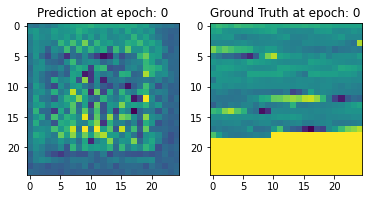

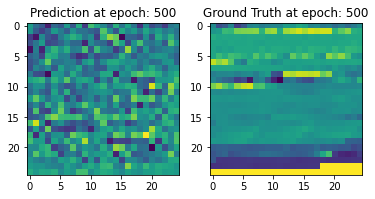

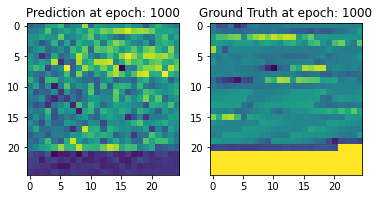

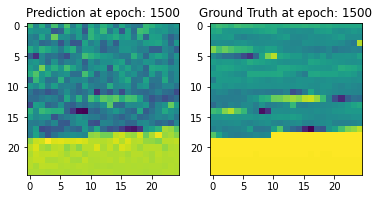

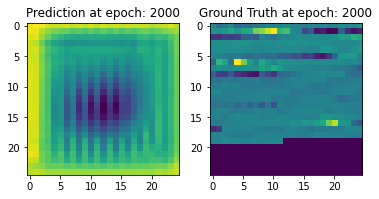

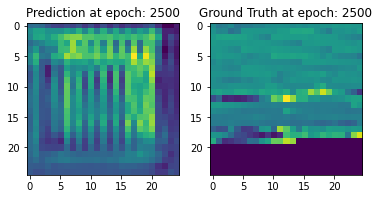

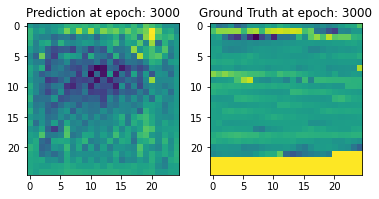

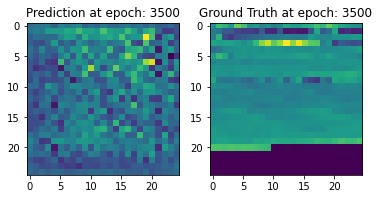

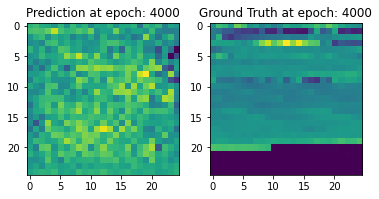

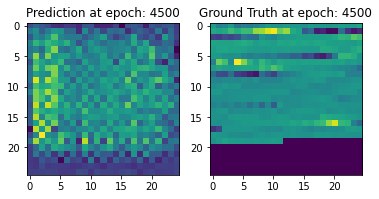

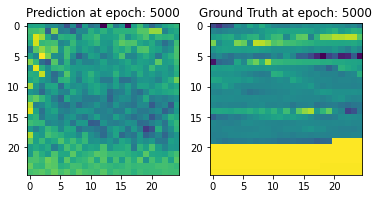

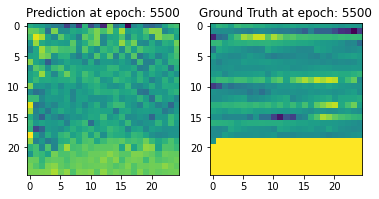

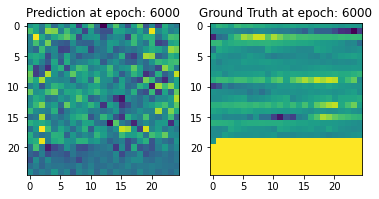

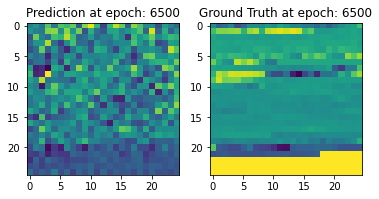

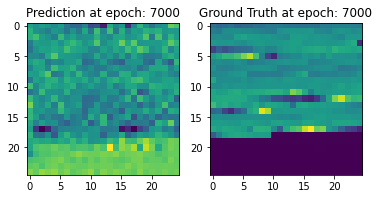

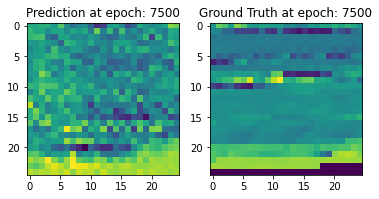

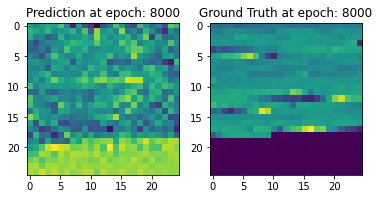

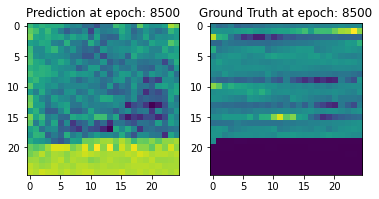

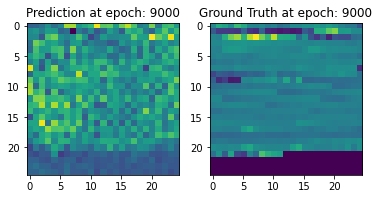

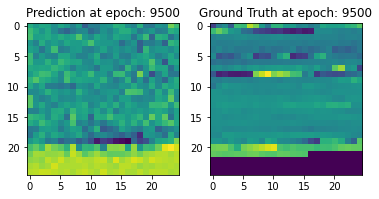

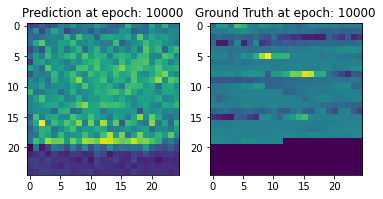

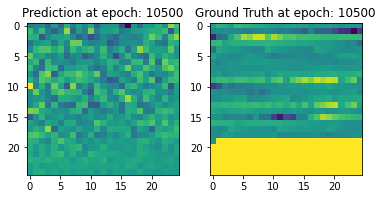

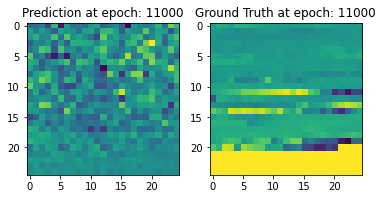

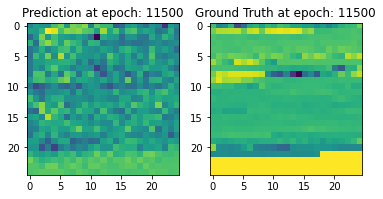

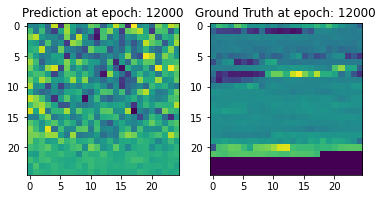

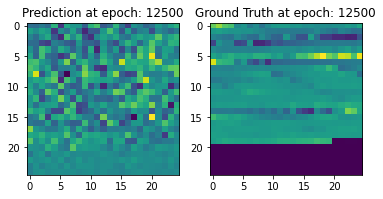

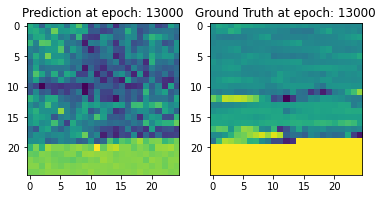

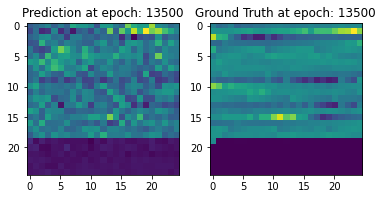

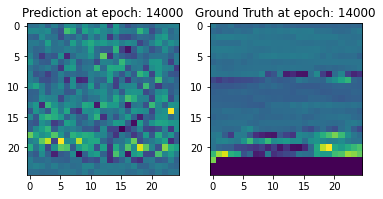

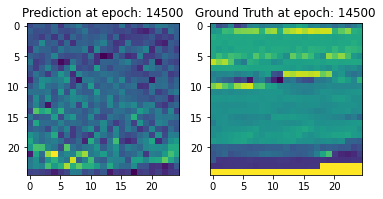

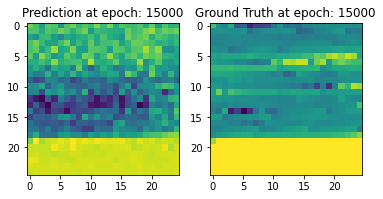

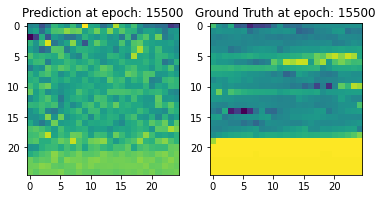

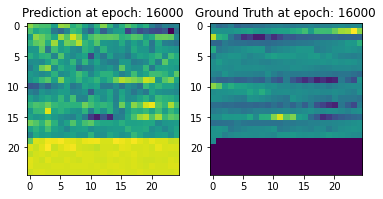

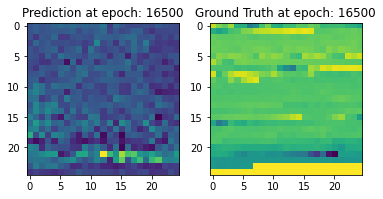

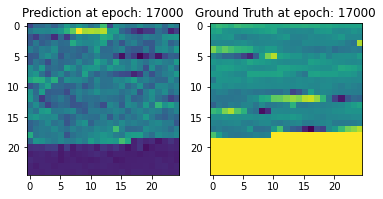

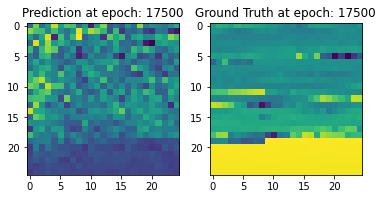

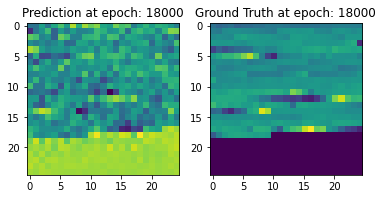

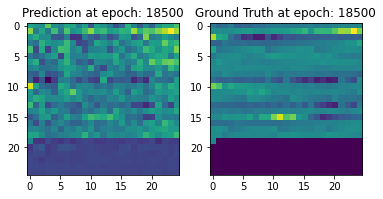

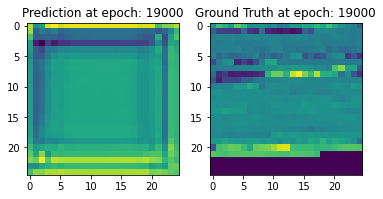

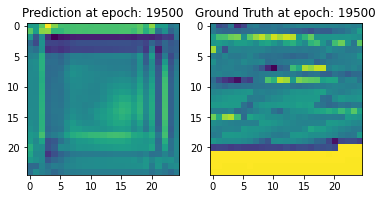

In [42]:
n_batch = 64
n_epochs = 20000
train(n_epochs, n_batch)

In [49]:
pred, Y_def_test = test()

d_loss: tf.Tensor(0.21827488, shape=(), dtype=float32) total_g_loss: tf.Tensor(0.46151617, shape=(), dtype=float32)
9/9 [==============================] - 3s 59ms/step


In [50]:
tf.keras.losses.MeanSquaredError()(Y_def_test, pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8005342>

In [39]:
a

NameError: name 'a' is not defined

In [44]:
# for i in range(pred.shape[0]):
#     fig, axs = plt.subplots(1, 2)
#     axs[0].imshow(pred[i, :, :, 0])
#     axs[1].imshow(Y_def_test[i, :, :, 0])

In [45]:
#os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [46]:
# increase batch size within GPU memory and trial run for some epochs
# change values for cond
# func for separate padding of output

In [47]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [51]:
plot_file = pv.read(r'C:\Users\Vaishnav Bhaskaran\GAN\Data\VTK_Data\With_Hole\Aluminium\NLGEOM_ON\Elastic\Compression_Vtk\Job_S9_C8_J7_Step-1_PART-1-1f001.vtu')

In [52]:
plotter = pv.Plotter()
plotter.add_mesh(plot_file)

<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x0000020A7A8238D0) at 0x0000020A83BDF280>

In [53]:
def denorm(f_tensor):
    epsilon = 1e-5
    std = tf.sqrt(fop_var + epsilon)
    f_tensor_dnorm = (f_tensor*std) + fop_mean

    return f_tensor_dnorm

In [54]:
a = tf.reshape(denorm(pred), (288, -1, 2))
y = tf.reshape(denorm(Y_def_test), (288, -1, 2))

In [55]:
plot_file.point_data.set_array(a[-2, :plot_file.n_points, 1], 'a')
plot_file.point_data.set_array(y[-2, :plot_file.n_points, 1], 'y')

In [56]:
plot_file.plot(scalars = 'a', text = 'Predicted stress')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [57]:
plot_file.plot(scalars = 'y', text = 'Actual stress')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)